In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install d2l==1.0.0-alpha0

## 16.4.2 The Stanford Natural Language Inference (SNLI) Dataset

* SNLI dataset -> 50만개 이상의 영어 문장

#16.4 Natural Language Inference and the Dataset
##16.4.1 Natural Language Inference

* 하나의 문장(premise, 전제)이 주어졌을 때 해당 문장이 다른 문장(hypothesis, 가설)에 의미적으로 수반(entail)되는지 결정하는 문제
* 관계는 세가지 유형으로 나뉨

|Label|설명|
|------|---|
|Entailment|같은 의미, 문장의 의미의 일반화 or 문장의 의미의 간략화|
|Contradiction|모순, 문장에 반대되는 일반화 or 특정 단어의 부정 or 기타 요소 투입|
|Neutral|중립, 문장 목적이 불분명 Or 치환되는 대상이 불분명|

* For example

|Premise|Label|Hypothesis|
|------|---|---|
|Two women are hugging each other.|Entailment|Two women are showing affection.|
|A man is running the coding example from Dive into Deep Learning.|contradiction|The man is sleeping.|
|The musicians are performing for us.|neutrality|The musicians are famous.|


In [ ]:
import os
import re
import torch
from torch import nn
from d2l import torch as d2l


d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

In [ ]:
#Reading the Dataset

def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [ ]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [ ]:
# data 분포 확인
# training data 550,000 pairs, test data 10,000 pairs

test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


## Defining a Class for Loading the Dataset


In [ ]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    # num_steps = text 시퀀스 길이
    # padding -> 시퀀스 길이가 num_steps가 될 때까지 시퀀스에 추가
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

In [ ]:
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [ ]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


18678

In [ ]:
# X[0] -> 전제, X[1] -> 가설

for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


# 16.5. Natural Language Inference: Using Attention


* Parikh et al. proposed to address natural language inference with attention mechanisms and called it a “decomposable attention model”

* https://arxiv.org/pdf/1606.01933.pdf?source=post_page---------------------------


Fig 16.5.1. This section feeds pretrained GloVe to an architecture based on attention and MLPs for natural language inference.

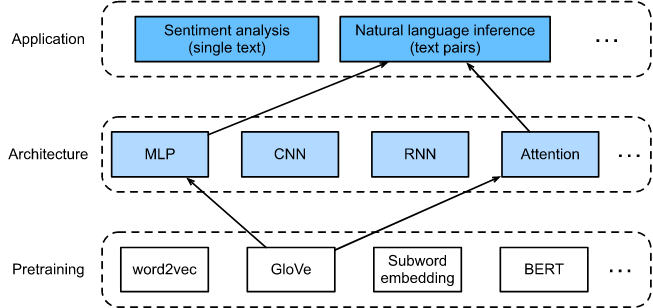

## 16.5.1. The model
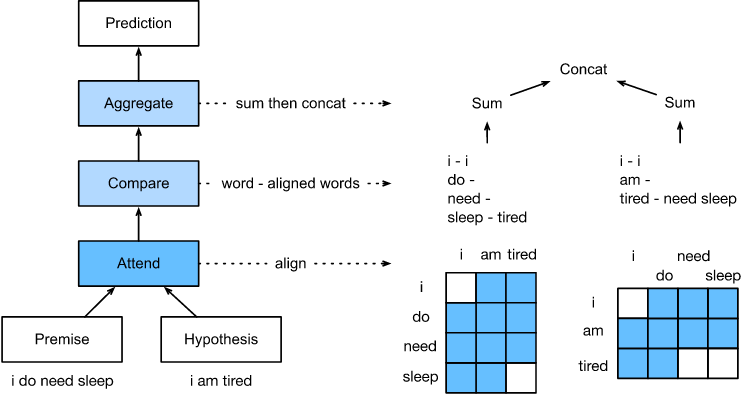

* Step 1: To create soft alignment matrix using neural attention
* Step 2: The alignment to decompose the task into subproblems
* Step 3: Merging the result of step 2 to produce the final classification

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Attending

* 하나의 텍스트 시퀀스의 토큰을 다음 시퀀스의 각 토큰에 정렬하는것
* 예를들어, the premise ("i do need sleep")이고,the hypothesis ("i am tired")라고 가정하자

|premise|hypothesis|
|------|---|
|"i"|"i"|
|"need sleep"|"tired"|

* soft alignment : attention weight를 사용하여 주변 단어를 보고 어떻게 변경할지 스스로 학습
* hard alignment : source sentences내 단어마다 target sentences에서 어떠한 단어로 변경할지 사람이 직접 지정

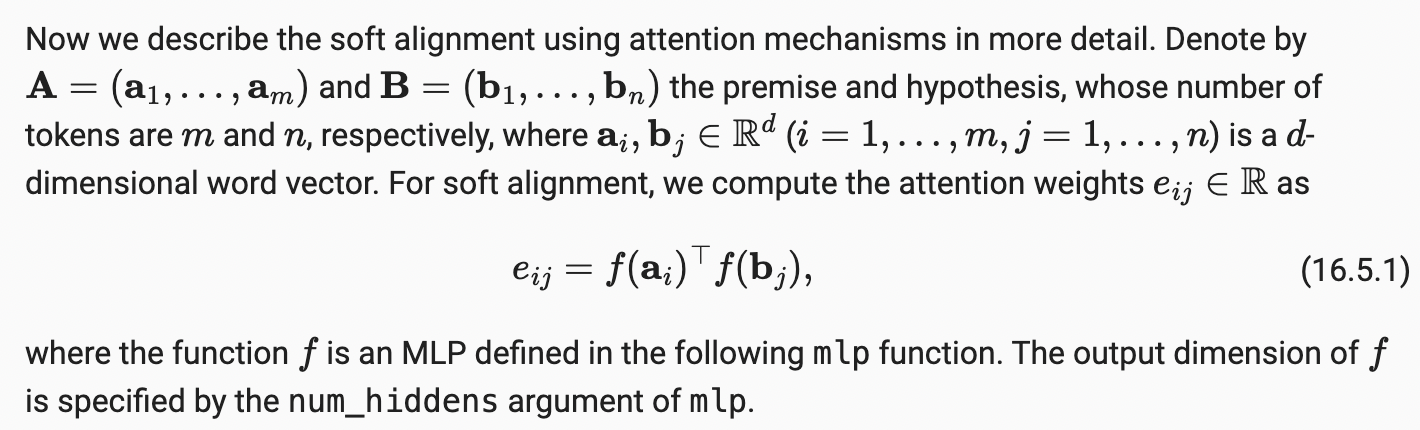


In [ ]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

* function f에서는 Input을 한쌍으로 함께 가져가는 것이 아니라 Promise 와 hypothesis 를 따로 가져감

* attention weight 정규화 -> hypothesis의 모든 토큰 벡터의 가중 평균을 계산하여 promise에서 인덱싱된 토큰 i와 soft alignment된 repsentation of hypothesis를 얻음

* Attend class에서 Input premises A를 갖는 soft alignment of hypothesis(beta)과 input hypothesis B를 갖는 soft alignment of premises (alpha)를 정의

In [ ]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

## Comparing

* 한 시퀀스의 토큰과 soft alignment가 적용된 다른 시퀀스의 토큰과 비교

* 예를들어, 위에서 hard alignment를 적용한 사례를 보면 attending Step에서 premise에서 "need"와 "sleep"이 모두 hypothesis의 "tired와 alignment 되어있다고 가정한다면 "tired-need sleep" pair를 비교

* Comparing step에서 one sequence로부터 concatenation of token을 공급하고, other sequence로부터 aligned tokens을 MNL 함수 g 로 보냄

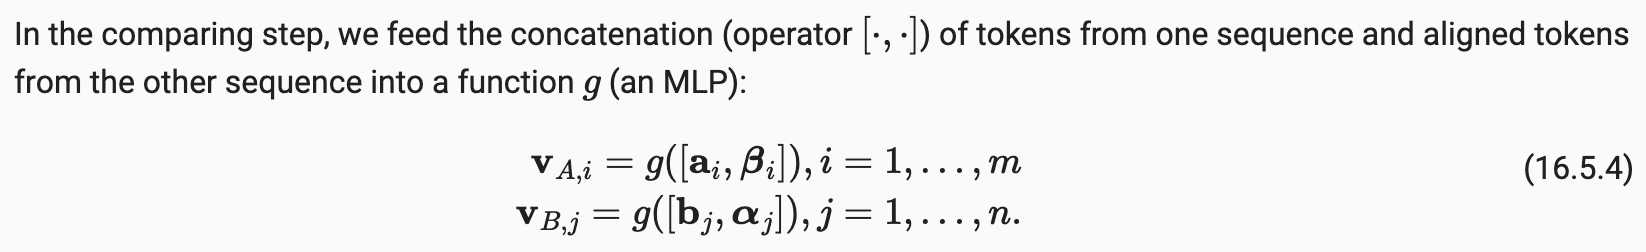

* Va,i는 premise token i와 Soft alignment가 적용된 모든 hypothesis 토큰 i 의 비교

* Vb,i는 hypothesis token j와 Soft alignment가 적용된 모든 premise 토큰 j 의 비교 

In [ ]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

## Aggregating

* 논리 관계를 추론하기 위해서 vector A와 B의 정보를 종합

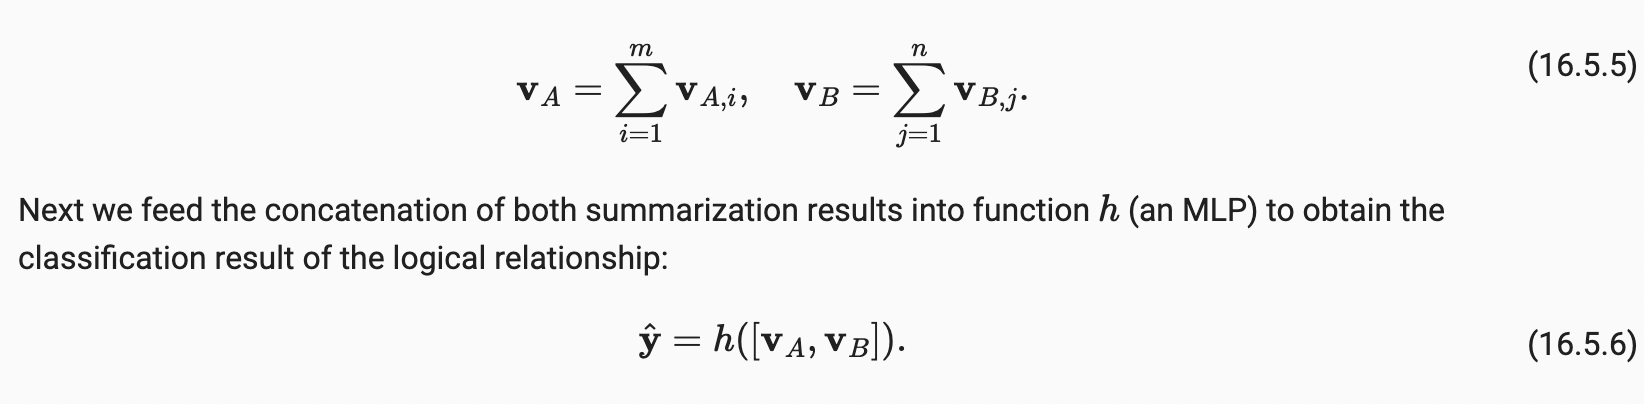

In [ ]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

## Putting All Things Together

In [ ]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

## Training and Evaluating the Model

In [ ]:
# Reading the dataset
# batch_size = 256, sequence length = 50
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Creating the Model

* 미리 훈련된 100 Dimensional GloVe embedding 사용 (for represent the input tokens)

* function f 와 g의 output dimension은 200으로 설정

* create a model instance -> intitalize parameters -> load the GloVe embedding -> intialize vectors of input tokens

In [ ]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

In [ ]:
## minibatch에서 premise와 hypothese와 같은 multiple input을 취하는 split_batch_multi_inputs 함수를 정의

def split_batch_multi_inputs(X, y, devices):
    """Split multi-input `X` and `y` into multiple devices."""
    X = list(zip(*[gluon.utils.split_and_load(
        feature, devices, even_split=False) for feature in X]))
    return (X, gluon.utils.split_and_load(y, devices, even_split=False))

loss 0.496, train acc 0.805, test acc 0.818
16523.9 examples/sec on [device(type='cuda', index=0)]


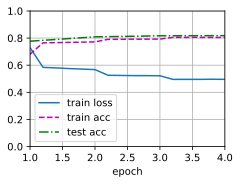

In [ ]:
# train & evaluate the model

lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
# 한쌍의 premise 와 hypothesis 사이의 논리적 관계를 출력하기 위해 prediction function 정의

def predict_snli(net, vocab, premise, hypothesis):
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [ ]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

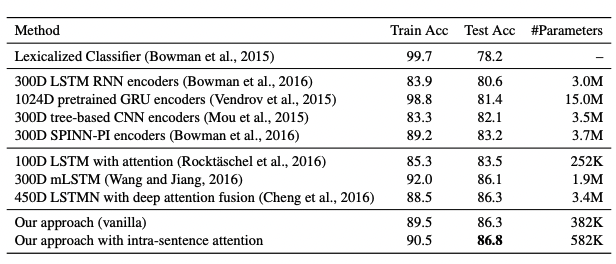